# Calibrating Qubits using OpenPulse

Contents
1. Introduction
1. Finding our qubit
1. Rabi experiment
1. 0 vs 1
1. Measuring T1
1. Ramsey experiment
1. Measuring T2
1. Dynamical Decoupling

# 1. Introduction

In [42]:
%matplotlib inline
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.10.0',
 'qiskit-aer': '0.3.2',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.13.0'}

In [45]:
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(hub='your-hub-name') # change to your hub name

backend = provider.get_backend('ibmq_boeblingen')
backend_config = backend.configuration()

In [46]:
from qiskit.tools.jupyter import backend_overview, backend_monitor
%qiskit_backend_monitor backend

UsageError: Line magic function `%qiskit_backend_monitor` not found.


The superconducting devices at IBM are routinely calibrated to determine the properties of each qubit. The calibration procedure determines the qubit frequency, coherence and energy relaxation times, and pulse parameters, among other things. In this notebook, we show how these parameters can be determined at the microwave level using Terra.Pulse.

For an introduction to the experiments, please see [this paper](https://arxiv.org/pdf/0812.1865.pdf) or [this paper](https://arxiv.org/abs/cond-mat/0703002) or [this paper](http://qulab.eng.yale.edu/documents/reprints/QIP_Devoret_squbit_review.pdf).

Note: Pulse is a fairly new component of Qiskit. Please contact abraham.asfaw@ibm.com if you find that something in this notebook is suddenly broken.

In [47]:
backend_defaults = backend.defaults()
backend_devicespec = pulse.PulseChannelSpec.from_backend(backend)
dt = backend_config.dt

# 2. Finding our qubit

In [48]:
# choose device to work on
# from qiskit import IBMQ
# IBMQ.load_account()

Define the frequency range that will be swept in search of the qubit.

In [49]:
qubit = 1
center_frequency_GHz = backend_defaults.qubit_freq_est[qubit]
# define frequencies to do VNA sweep
import numpy as np
frequency_span_kHz = 20000
frequency_step_kHz = 1000

frequency_min = center_frequency_GHz - frequency_span_kHz/2.e6
frequency_max = center_frequency_GHz + frequency_span_kHz/2.e6
frequencies_GHz = np.arange(frequency_min, frequency_max, frequency_step_kHz/1e6)
print(frequencies_GHz)

[4.83729919 4.83829919 4.83929919 4.84029919 4.84129919 4.84229919
 4.84329919 4.84429919 4.84529919 4.84629919 4.84729919 4.84829919
 4.84929919 4.85029919 4.85129919 4.85229919 4.85329919 4.85429919
 4.85529919 4.85629919]


Define drive and measurement pulse parameters for the experiment

In [50]:
# drive pulse parameters
drive_power = 0.01
drive_samples = 128
drive_sigma = 16

# creating drive pulse
drive_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power,
                                 sigma=drive_sigma, name='mydrivepulse')
drive_pulse_qubit = drive_pulse(backend_devicespec.qubits[qubit].drive)

# measurement pulse parameters
meas_amp = 0.05
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# creating measurement pulse
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='mymeasurepulse')
meas_pulse_qubit = meas_pulse(backend_devicespec.qubits[qubit].measure)

# create acquire pulse
acq_cmd=pulse.Acquire(duration=meas_samples)
acq_cmd_qubit = acq_cmd(backend_devicespec.qubits, backend_devicespec.memoryslots)

# combined measure and acquire pulse
measure_and_acquire_qubit = meas_pulse_qubit | acq_cmd_qubit

# scalefactor for received data
scale_factor = 1e-10

Once the pulse parameters have been defined, we can create the pulse schedules corresponding to each frequency in the sweep.

In [51]:
# schedules
schedules = []
schedule_LOs = []

num_shots_per_frequency = 256
for jj, drive_frequency in enumerate(frequencies_GHz):
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Frequency = {}".format(drive_frequency))
    this_schedule += drive_pulse_qubit
    this_schedule += measure_and_acquire_qubit << this_schedule.duration

    schedules.append(this_schedule)
    thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: drive_frequency})
    schedule_LOs.append(thisLO)
        
VNASweep_experiment_qobj = assemble(schedules, backend = backend, 
                            meas_level=1, meas_return='single', 
                            shots=num_shots_per_frequency,
                            schedule_los = schedule_LOs
                            )

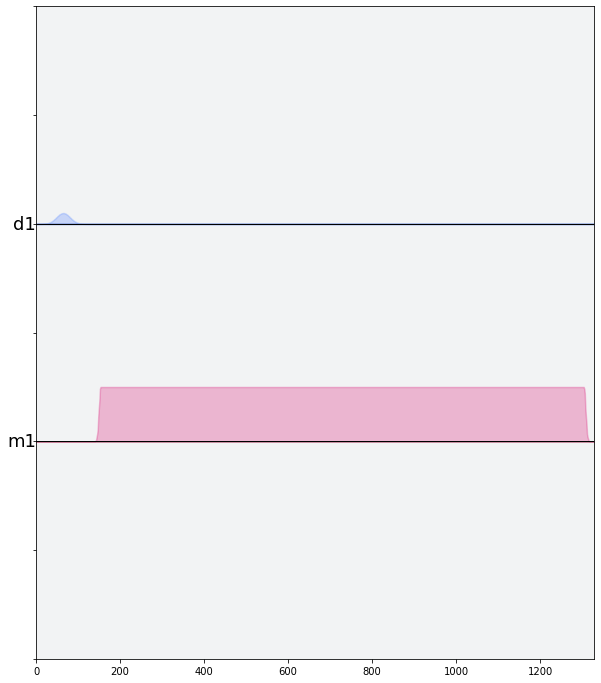

In [52]:
schedules[-1].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [53]:
job = backend.run(VNASweep_experiment_qobj)

In [54]:
from qiskit.tools.monitor import job_monitor
print(job.job_id())
job_monitor(job)

5db6a5496bae840018b17c0d
Job Status: job has successfully run


In [55]:
job = backend.retrieve_job(job.job_id())
VNASweep_results = job.result(timeout=3600)

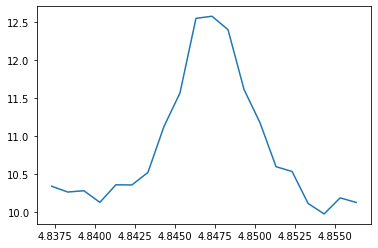

In [56]:
plot_X = frequencies_GHz
plot_Y = []
for kk, drive_frequency in enumerate(frequencies_GHz):
    thisfrequency_results = VNASweep_results.get_memory(kk)*scale_factor
    plot_Y.append(  np.mean(thisfrequency_results[:, qubit])  )

import matplotlib.pyplot as plotter
plotter.plot(plot_X, plot_Y)

In [57]:
rough_frequency_qubit = frequencies_GHz [
    np.where( plot_Y == np.max(plot_Y))[0]
                ].tolist()[0]
rough_frequency_qubit = round(rough_frequency_qubit, 5)
print(rough_frequency_qubit)


4.8473


# 3. Rabi experiment

Once we know the frequency of our qubit, the next step is to determine the strength of a $\pi$ pulse.

In [58]:
# Rabi experiment parameters
num_Rabi_points = 64
num_shots_per_point = 256

# drive parameters
drive_power_min = 0
drive_power_max = 0.1
drive_powers = np.linspace(drive_power_min, drive_power_max, num_Rabi_points)
drive_samples = 128
drive_sigma = 16

In [59]:
# create schedules for Rabi experiment 
Rabi_schedules = []
Rabi_schedule_LOs = []
for ii, drive_power in enumerate(drive_powers):
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power, 
                                    sigma=drive_sigma, name='rabi_pulse_{}'.format(ii))
    rabi_pulse_qubit = rabi_pulse(backend_devicespec.qubits[qubit].drive)
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Rabi drive = {}".format(drive_power))
    this_schedule += rabi_pulse_qubit
    this_schedule += measure_and_acquire_qubit << this_schedule.duration
    
    Rabi_schedules.append(this_schedule)
    thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: rough_frequency_qubit})
    Rabi_schedule_LOs.append(thisLO)

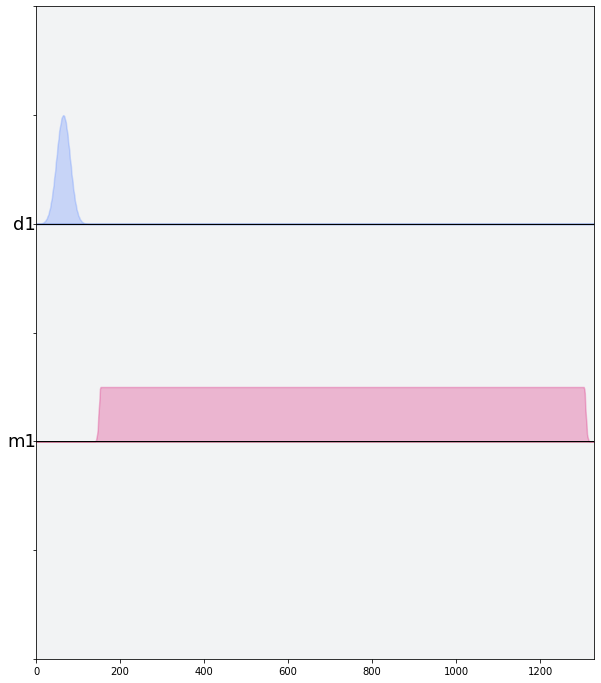

In [60]:


Rabi_schedules[-1].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [61]:
rabi_experiment_qobj = assemble (Rabi_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = Rabi_schedule_LOs
                                )

In [62]:
job = backend.run(rabi_experiment_qobj)
print(job.job_id())
job_monitor(job)

5db6a58a1cd1b900189ffb21
Job Status: job has successfully run


In [63]:
job = backend.retrieve_job(job.job_id())
Rabi_results = job.result(timeout=3600)

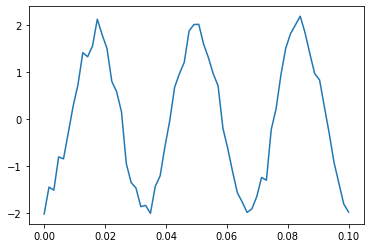

In [64]:
plot_X = drive_powers
plot_Y = []
for jj, drive_power in enumerate(drive_powers):
    thispower_results = Rabi_results.get_memory(jj)*scale_factor
    plot_Y.append( thispower_results[qubit] )

import matplotlib.pyplot as plotter
plot_Y = plot_Y - np.mean(plot_Y)
plotter.plot(plot_X, plot_Y)

C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\optimize\minpack.py:725: ComplexWarning: Casting complex values to real discards the imaginary part
  ydata = ydata.astype(float)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Pi Amplitude 0.016793


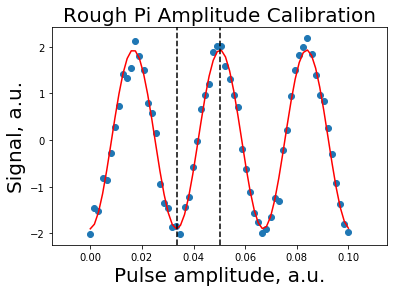

In [65]:
from scipy.optimize import curve_fit

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, plot_X, plot_Y, [3.0  ,0.0  ,0.04  ,0])

#get the pi amplitude
first_peak = abs(np.pi-fitparams[3])*fitparams[2]/(2*np.pi)
pi_amp = abs(fitparams[2]/2)

plotter.scatter(plot_X, plot_Y)
plotter.plot(plot_X, fit_func(plot_X, *fitparams), color='red')
plotter.axvline(first_peak, color='black', linestyle='dashed')
plotter.axvline(first_peak + pi_amp, color='black', linestyle='dashed')
plotter.xlabel('Pulse amplitude, a.u.', fontsize=20)
plotter.ylabel('Signal, a.u.', fontsize=20)
plotter.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

# 4. 0 vs 1

One our $\pi$ pulses have been calibrated, we can now create the state $\vert1\rangle$ with reasonably probability. We can use this to find out what the states $\vert0\rangle$ and $\vert1\rangle$ look like in our measurements.

In [66]:
# Rabi experiment parameters
num_shots_gndexc = 512

# drive parameters
drive_power = pi_amp
print(drive_power)

0.016792741482204512


In [67]:
# create schedules for Rabi experiment 
gndexc_schedules = []
gndexc_schedule_LOs = []

pi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=pi_amp, 
                                sigma=drive_sigma, name='pi_pulse'.format(ii))
pi_pulse_qubit = pi_pulse(backend_devicespec.qubits[qubit].drive)
    
# ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure_and_acquire_qubit << gnd_schedule.duration
thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: rough_frequency_qubit})
    
# excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += pi_pulse_qubit
exc_schedule += measure_and_acquire_qubit << exc_schedule.duration
thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: rough_frequency_qubit})

gndexc_schedules.append(gnd_schedule)
gndexc_schedules.append(exc_schedule)
gndexc_schedule_LOs.append(thisLO)
gndexc_schedule_LOs.append(thisLO)

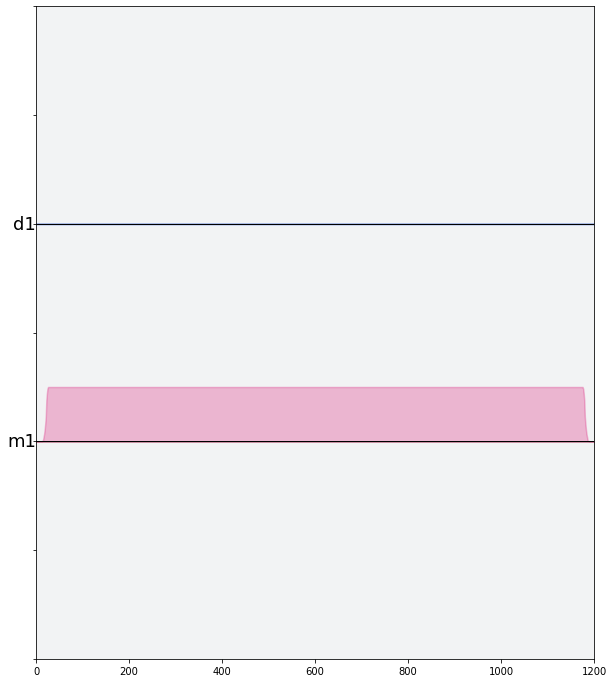

In [68]:
gndexc_schedules[0].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

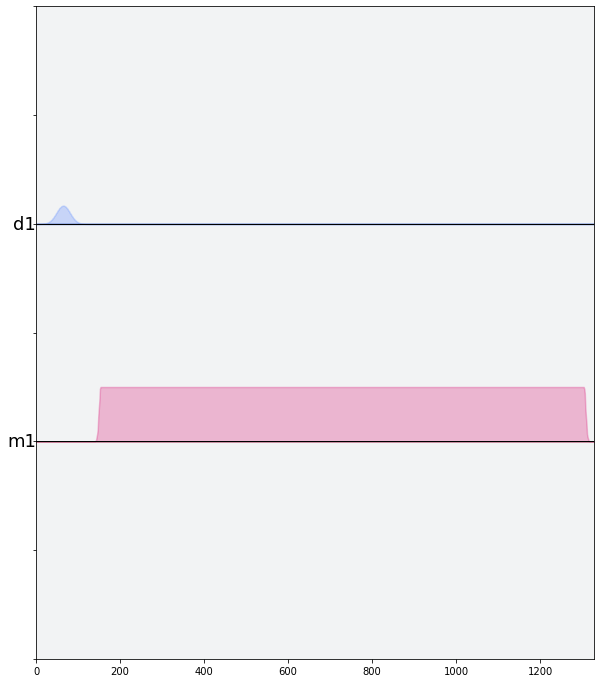

In [69]:
gndexc_schedules[1].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [70]:
gndexc_experiment_qobj = assemble (gndexc_schedules, backend = backend, 
                            meas_level=1, meas_return='single',
                            shots=num_shots_gndexc,
                            schedule_los = gndexc_schedule_LOs
                                )

In [71]:
job = backend.run(gndexc_experiment_qobj)
print(job.job_id())
job_monitor(job)

5db6a606d691f000113ff70f
Job Status: job has successfully run


In [72]:
job = backend.retrieve_job(job.job_id())
gndexc_results = job.result(timeout=3600)

Text(0.5, 0, 'Q (a.u.)')

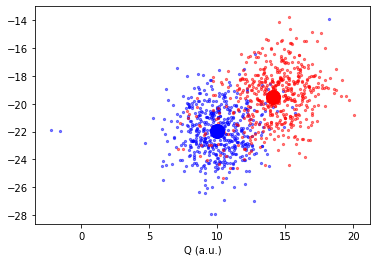

In [73]:
gnd_results = gndexc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gndexc_results.get_memory(1)[:, qubit]*scale_factor


plotter.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis',c='blue',alpha=0.5, label='state_0')
plotter.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis',c='red',alpha=0.5, label='state_1')
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plotter.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
                s=200, cmap='viridis',c='blue',alpha=1.0, label='state_0_mean')
plotter.scatter(np.real(mean_exc), np.imag(mean_exc), 
                s=200, cmap='viridis',c='red',alpha=1.0, label='state_1_mean')

plotter.xlabel('I (a.u.)')
plotter.xlabel('Q (a.u.)')

In [74]:
def get_01(IQ_data):
    dist_0 = np.linalg.norm(np.array([
                        np.real(IQ_data) - np.real(mean_gnd),
                        np.imag(IQ_data) - np.imag(mean_gnd)
                        ]))
    dist_1 = np.linalg.norm(np.array([
                        np.real(IQ_data) - np.real(mean_exc),
                        np.imag(IQ_data) - np.imag(mean_exc)
                        ]))
    
    if dist_1 <= dist_0:
        return 1
    else:
        return 0

    
print(get_01(mean_gnd), get_01(mean_exc))

0 1


# 5. Measuring T1

In [75]:
# T1 experiment parameters
time_max_us = 500
time_step_us = 2
times_us = np.arange(1, time_max_us, time_step_us)
num_shots_per_point = 512

# drive parameters
drive_power = pi_amp
print(drive_power)

0.016792741482204512


In [76]:
# create schedules for Ramsey experiment 
T1_schedules = []
T1_schedule_LOs = []

T1_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power, 
                                sigma=drive_sigma, name='T1_pulse')
T1_pulse_qubit = T1_pulse(backend_devicespec.qubits[qubit].drive)
thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: rough_frequency_qubit})
for ii, delay_time_us in enumerate(times_us):
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="T1 delay = {} us".format(delay_time_us))
    this_schedule += T1_pulse_qubit
    this_schedule |= (measure_and_acquire_qubit << int(delay_time_us*1000/dt))
    
    T1_schedules.append(this_schedule)
    T1_schedule_LOs.append(thisLO)

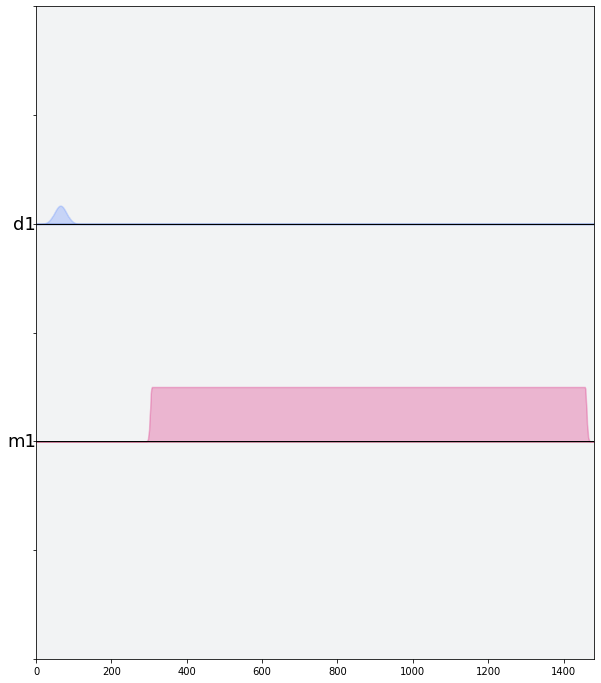

In [77]:
T1_schedules[0].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [78]:
T1_experiment_qobj = assemble (T1_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = T1_schedule_LOs
                                )

In [79]:
job = backend.run(T1_experiment_qobj)
print(job.job_id())
job_monitor(job)

5db6a6e31cd1b900189ffb25
Job Status: job has successfully run


In [80]:
job = backend.retrieve_job(job.job_id())
T1_results = job.result(timeout=3600)

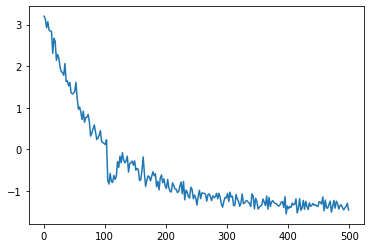

In [81]:
plot_X = times_us
plot_Y = []
for jj, delay_time_us in enumerate(times_us):
    thisdelay_results = T1_results.get_memory(jj)*scale_factor
    plot_Y.append( thisdelay_results[qubit] )

plotter.plot(plot_X, plot_Y)

T1 from backend = 65.37301079547916 us


Text(0, 0.5, 'Measured signal, a.u.')

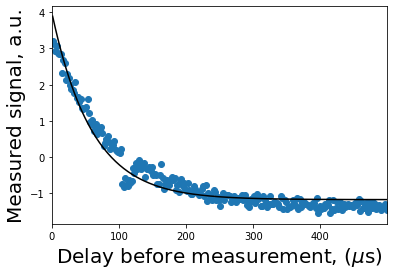

In [82]:
from scipy.optimize import curve_fit

fit_func2 = lambda x,A,B: (A*np.exp(-x/59.8)+B)

#Fit the data
fitparams2, conv2 = curve_fit(fit_func2, plot_X,
                                      plot_Y,
                                      [-1.0,-11])

print(f"T1 from backend = {backend.properties().qubits[qubit][0].value} us")

plotter.scatter(plot_X, plot_Y)
plotter.plot(plot_X, fit_func2(plot_X, *fitparams2), color='black')
plotter.xlim(0, np.max(plot_X))
plotter.xlabel('Delay before measurement, ($\mu$s)', fontsize=20)
plotter.ylabel('Measured signal, a.u.', fontsize=20)

# 6. Ramsey experiment

Now, we determine both $T_2$ and the qubit frequency to better precision. This is done using a Ramsey pulse sequence.

In this pulse sequence, we first apply a $\pi/2$ pulse, wait some time $\Delta t$, and then apply another $\pi/2$ pulse. 

In [83]:
# Ramsey experiment parameters
time_max_us = 100
time_step_us = 0.25
times_us = np.arange(1, time_max_us, time_step_us)
num_shots_per_point = 256

# drive parameters
drive_power = pi_amp/2
print(drive_power)

0.008396370741102256


In [84]:
# create schedules for Ramsey experiment 
Ramsey_schedules = []
Ramsey_schedule_LOs = []
ramsey_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power, 
                                sigma=drive_sigma, name='ramsey_pulse')
ramsey_pulse_qubit = ramsey_pulse(backend_devicespec.qubits[qubit].drive)
thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: rough_frequency_qubit})
for ii, delay_time_us in enumerate(times_us):
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Ramsey delay = {} us".format(delay_time_us))
    this_schedule += ramsey_pulse_qubit
    this_schedule |= (ramsey_pulse_qubit << int(this_schedule.duration+delay_time_us*1000/dt))
    this_schedule |= (measure_and_acquire_qubit << this_schedule.duration)
    
    Ramsey_schedules.append(this_schedule)
    Ramsey_schedule_LOs.append(thisLO)

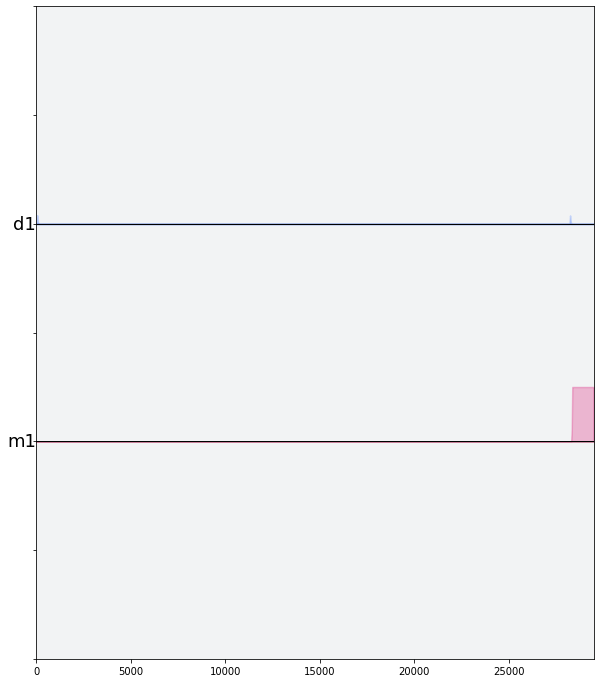

In [85]:
Ramsey_schedules[-1].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [86]:
ramsey_experiment_qobj = assemble (Ramsey_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = Ramsey_schedule_LOs
                                )

In [87]:
job = backend.run(ramsey_experiment_qobj)
print(job.job_id())
job_monitor(job)

5db6aa438fecb200125e71e2
Job Status: job has successfully run


In [88]:
job = backend.retrieve_job(job.job_id())
Ramsey_results = job.result(timeout=3600)

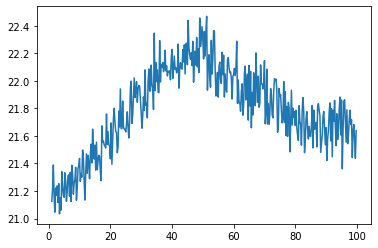

In [89]:
plot_X = times_us
plot_Y = []

for jj, delay_time_us in enumerate(times_us):
    thisdelay_results = Ramsey_results.get_memory(jj)[qubit]*scale_factor
    plot_Y.append(np.mean(thisdelay_results))

plotter.plot(plot_X, (plot_Y))

df = 0.01101894025746676 MHz
T2p = 70.98601297330386 us
T2 from backend = 127.3768968947157 us


Text(0.5, 1.0, 'Rough $\\Delta$f Calibration')

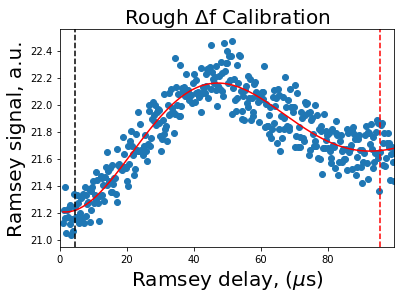

In [90]:
from scipy.optimize import curve_fit

fit_func = lambda x,A,T,phi,T2p,B: (A*np.exp(-x/T2p)*(np.sin(2*np.pi*x/T+phi))+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, plot_X,
                                      plot_Y,
                                      [1.0,10,0,4,34])

#off-resonance component
delT = fitparams[1]
delf_MHz = 1./(delT)
print(f"df = {delf_MHz} MHz")
first_peak = (np.pi-fitparams[2])*delT/(2*np.pi) + delT/4
second_peak = first_peak + delT
print(f"T2p = {fitparams[3]} us")
print(f"T2 from backend = {backend.properties().qubits[qubit][1].value} us")
#get the pi amplitude
plotter.scatter(plot_X, plot_Y)
plotter.plot(plot_X, fit_func(plot_X, *fitparams), color='red')
plotter.axvline(first_peak, color='black', linestyle='dashed')
plotter.axvline(second_peak, color='red', linestyle='dashed')
plotter.xlim(0, np.max(plot_X))
plotter.xlabel('Ramsey delay, ($\mu$s)', fontsize=20)
plotter.ylabel('Ramsey signal, a.u.', fontsize=20)
plotter.title('Rough $\Delta$f Calibration', fontsize=20)

In [91]:
precise_frequency_qubit_plus = round(rough_frequency_qubit + delf_MHz/1e3, 5)
precise_frequency_qubit_minus = round(rough_frequency_qubit - delf_MHz/1e3, 5)
print(f"{rough_frequency_qubit}->{precise_frequency_qubit_plus} or {precise_frequency_qubit_minus}")

4.8473->4.84731 or 4.84729


# 7. Measuring T2

In [92]:
# T2 experiment parameters
time_max_us = 125
time_step_us = 0.5
times_us = np.arange(1, time_max_us, time_step_us)
num_shots_per_point = 512

# drive parameters
drive_power_1 = pi_amp/2
drive_power_2 = pi_amp
print(drive_power_1)
print(drive_power_2)

0.008396370741102256
0.016792741482204512


In [93]:
# create schedules for Ramsey experiment 
T2_schedules = []
T2_schedule_LOs = []

T2_pulse_pio2 = pulse_lib.gaussian(duration=drive_samples, amp=drive_power_1, 
                                sigma=drive_sigma, name='T2_pio2_pulse')
T2_pulse_pio2_qubit = T2_pulse_pio2(backend_devicespec.qubits[qubit].drive)
T2_pulse_pi = pulse_lib.gaussian(duration=drive_samples, amp=drive_power_2, 
                                sigma=drive_sigma, name='T2_pi_pulse')
T2_pulse_pi_qubit = T2_pulse_pi(backend_devicespec.qubits[qubit].drive)
thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: precise_frequency_qubit_minus})
for ii, delay_time_us in enumerate(times_us):
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="T2 delay = {} us".format(delay_time_us))
    this_schedule |= T2_pulse_pio2_qubit
    this_schedule |= (T2_pulse_pi_qubit << int(this_schedule.duration + 
                                               delay_time_us*1000/dt))
    this_schedule |= (T2_pulse_pio2_qubit << int(this_schedule.duration + 
                                               delay_time_us*1000/dt))
    this_schedule |= (measure_and_acquire_qubit << int(this_schedule.duration))
    
    T2_schedules.append(this_schedule)
    T2_schedule_LOs.append(thisLO)

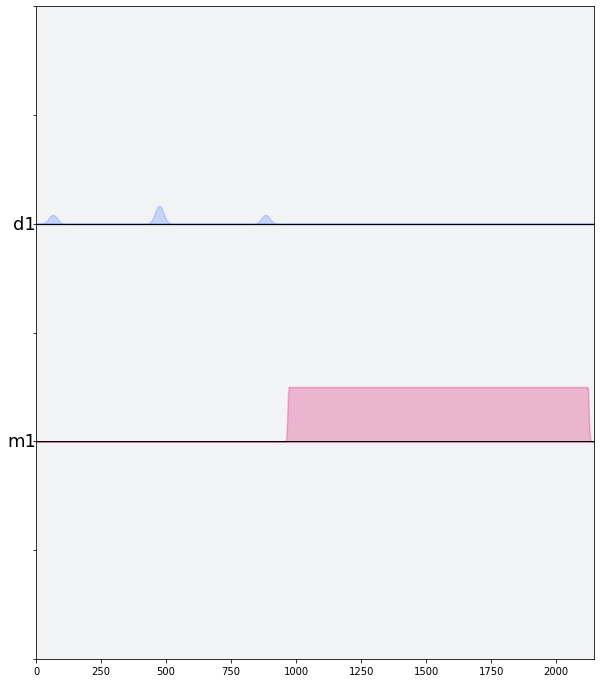

In [94]:
T2_schedules[0].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [95]:
T2_experiment_qobj = assemble (T2_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = T2_schedule_LOs
                                )

In [96]:
job = backend.run(T2_experiment_qobj)
print(job.job_id())
job_monitor(job)

5db6b05e1ea0a800183faf4f
Job Status: job has successfully run


In [97]:
T2job = backend.retrieve_job(job.job_id()) 
T2_results = T2job.result(timeout=3600)

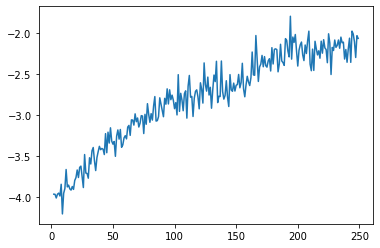

In [98]:
plot_X = 2.*times_us
plot_Y = []
for jj, delay_time_us in enumerate(times_us):
    thisdelay_results = T2_results.get_memory(jj)*scale_factor
    plot_Y.append( thisdelay_results[qubit] )

plotter.plot(plot_X, plot_Y)
T2y_echo = plot_Y
T2x_echo = plot_X

T2 from backend = 127.3768968947157 us


Text(0, 0.5, 'Measured signal, a.u.')

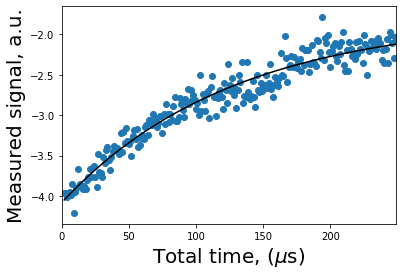

In [99]:
from scipy.optimize import curve_fit

T2guess = backend.properties().qubits[qubit][1].value

fit_func2 = lambda x,A,B: (A*np.exp(-x/T2guess)+B)
#Fit the data
fitparams2, conv2 = curve_fit(fit_func2, plot_X,
                                      plot_Y,
                                      [-2.0,1.0])

print(f"T2 from backend = {backend.properties().qubits[qubit][1].value} us")

plotter.scatter(plot_X, plot_Y)
plotter.plot(plot_X, fit_func2(plot_X, *fitparams2), color='black')
plotter.xlim(0, np.max(plot_X))
plotter.xlabel('Total time, ($\mu$s)', fontsize=20)
plotter.ylabel('Measured signal, a.u.', fontsize=20)

In [100]:
# measurement pulse parameters
meas_amp = 0.1
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# creating measurement pulse
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='mymeasurepulse')
meas_pulse_qubit = meas_pulse(backend_devicespec.qubits[qubit].measure)

# create acquire pulse
acq_cmd=pulse.Acquire(duration=meas_samples)
acq_cmd_qubit = acq_cmd(backend_devicespec.qubits, backend_devicespec.memoryslots)

# combined measure and acquire pulse
measure_and_acquire_qubit = meas_pulse_qubit | acq_cmd_qubit

# scalefactor for received data
scale_factor = 1e-10

# 8. Doing CPMG

In [101]:
# T2 experiment parameters
tau_us_min = 1
tau_us_max = 30
tau_step_us = 0.1
taus_us = np.arange(tau_us_min, tau_us_max, tau_step_us)
num_shots_per_point = 512
ncpmg = 10

# drive parameters
drive_power_1 = pi_amp/2
drive_power_2 = pi_amp
print(f"Total time ranges from {2.*ncpmg*taus_us[0]} to {2.*ncpmg*taus_us[-1]} us")

Total time ranges from 20.0 to 598.0000000000006 us


In [102]:
# create schedules for Ramsey experiment 
T2cpmg_schedules = []
T2cpmg_schedule_LOs = []

T2cpmg_pulse_pio2 = pulse_lib.gaussian(duration=drive_samples, amp=drive_power_1, 
                                sigma=drive_sigma, name='T2cpmg_pio2_pulse')
T2cpmg_pulse_pio2_qubit = T2cpmg_pulse_pio2(backend_devicespec.qubits[qubit].drive)
T2cpmg_pulse_pi = pulse_lib.gaussian(duration=drive_samples, amp=drive_power_2, 
                                sigma=drive_sigma, name='T2cpmg_pi_pulse')
T2cpmg_pulse_pi_qubit = T2cpmg_pulse_pi(backend_devicespec.qubits[qubit].drive)
thisLO = pulse.LoConfig({backend_devicespec.qubits[qubit].drive: precise_frequency_qubit_minus})
for ii, delay_time_us in enumerate(taus_us):
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="T2cpmg delay = {} us".format(delay_time_us))
    this_schedule |= T2cpmg_pulse_pio2_qubit
    this_schedule |= (T2cpmg_pulse_pi_qubit << int(this_schedule.duration + 
                                               delay_time_us*1000/dt))
    for _ in range(ncpmg-1):
        this_schedule |= (T2cpmg_pulse_pi_qubit << int(this_schedule.duration + 
                                                   2*delay_time_us*1000/dt))
    this_schedule |= (T2cpmg_pulse_pio2_qubit << int(this_schedule.duration + 
                                               delay_time_us*1000/dt))
    
    this_schedule |= (measure_and_acquire_qubit << int(this_schedule.duration))
    
    T2cpmg_schedules.append(this_schedule)
    T2cpmg_schedule_LOs.append(thisLO)

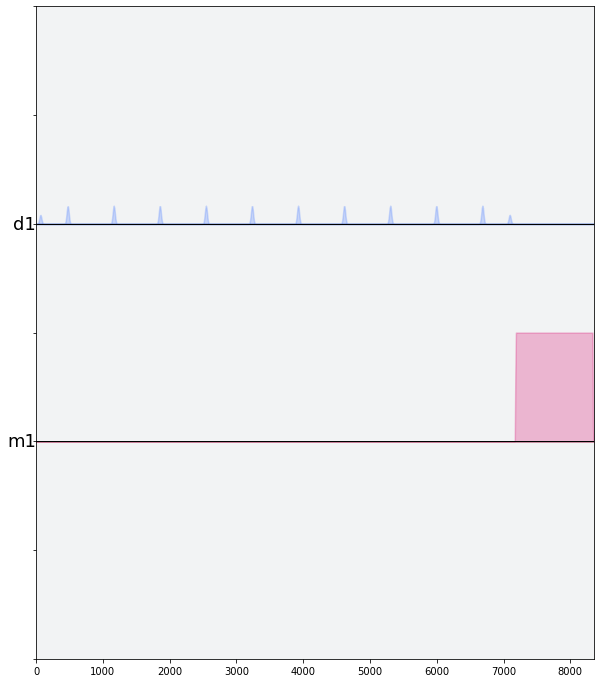

In [103]:
T2cpmg_schedules[0].draw(channels_to_plot=[backend_devicespec.qubits[qubit].measure, 
                                           backend_devicespec.qubits[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)

In [104]:
T2cpmg_experiment_qobj = assemble (T2cpmg_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = T2cpmg_schedule_LOs
                                )

In [105]:
job = backend.run(T2cpmg_experiment_qobj)
print(job.job_id())
job_monitor(job)

5db6b198d691f000113ff726
Job Status: job has successfully run


In [106]:
T2cpmgjob = backend.retrieve_job(job.job_id())
T2cpmg_results = T2cpmgjob.result(timeout=3600)

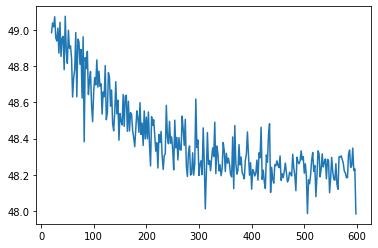

In [107]:
plot_X = 2.*ncpmg*taus_us
plot_Y = []
for jj, delay_time_us in enumerate(taus_us):
    thisdelay_results = T2cpmg_results.get_memory(jj)*scale_factor
    plot_Y.append( thisdelay_results[qubit] )

plotter.plot(plot_X, plot_Y)
T2y_cpmg = plot_Y
T2x_cpmg = plot_X

T2 from backend = 127.3768968947157 us


Text(0, 0.5, 'Measured signal, a.u.')

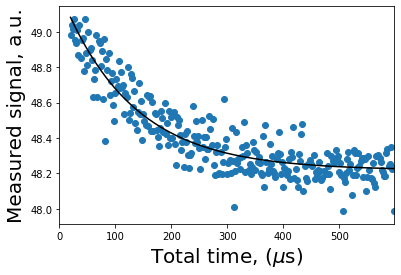

In [108]:
from scipy.optimize import curve_fit

T2guess = backend.properties().qubits[qubit][1].value
fit_func2 = lambda x,A,B: (A*np.exp(-x/T2guess)+B)
#Fit the data
fitparams2, conv2 = curve_fit(fit_func2, plot_X,
                                      plot_Y,
                                      [-2.0,1.0])

print(f"T2 from backend = {T2guess} us")

plotter.scatter(plot_X, plot_Y)
plotter.plot(plot_X, fit_func2(plot_X, *fitparams2), color='black')
plotter.xlim(0, np.max(plot_X))
plotter.xlabel('Total time, ($\mu$s)', fontsize=20)
plotter.ylabel('Measured signal, a.u.', fontsize=20)